## 1. Data Handling and Cleaning 

This section deals with importing our data and preparing it to later use for our trading strategies. We also calculate the 3-2-1 crack spread and analyse its distribution. 

### 1.1 Downloading Libraries and Importing Data  

We import the core Python libraries used throughout the project:

- `pandas` and `numpy` for data manipulation and basic statistics  
- `yfinance` to download futures prices for WTI crude oil, RBOB gasoline, and heating oil  
- `matplotlib` for plotting and visual inspection of the time series 

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

We pull daily **front-month continuous futures** for:

- WTI Crude Oil: `CL=F`  
- RBOB Gasoline: `RB=F`  
- Heating Oil: `HO=F`  

In [7]:
# Importing data 

start_date = '2015-01-01'
tickers = ["CL=F", "RB=F", "HO=F"] # Crude oil, Gasoline and Heating Oil futures

data = yf.download(tickers, start = start_date)["Close"]

C:\Users\adv_shl\AppData\Local\Temp\ipykernel_9908\1098231018.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start = start_date)["Close"]
[*********************100%***********************]  3 of 3 completed


The sample runs from **2015-01-01** to **2025-11-25** (approximately “today”), giving us a long enough history to capture:

- Multiple refining cycles  
- Different macro regimes  
- Stress periods in energy markets  

In [9]:
data

Ticker,CL=F,HO=F,RB=F
Date,,,
2015-01-02,52.689999,1.7957,1.4334
2015-01-05,50.040001,1.7492,1.3814
2015-01-06,47.930000,1.7262,1.3543
2015-01-07,48.650002,1.6999,1.3376
2015-01-08,48.790001,1.7110,1.3409
...,...,...,...
2025-11-19,59.439999,2.6357,1.9321
2025-11-20,59.139999,2.5333,1.9184
2025-11-21,58.060001,2.4564,1.8834


After downloading, we:

1. Keep only the adjusted close prices (settlement-equivalent series from Yahoo Finance).  
2. Rename the columns to shorter tickers (`CL`, `RB`, `HO`) for convenience.  
3. Drop rows with missing values to ensure that crude, gasoline, and heating oil are aligned on the same dates.  
4. Sort the index by date to make rolling-window calculations and backtests well-defined.

The result is a clean, daily panel of three synchronized futures prices that forms the basis for all crack spread calculations that follow.


In [11]:
df = data.copy()

df.columns = ["CL", "RB", "HO"]          # cleaner names
df = df.dropna(how="any")                # remove rows with missing prices
df = df.sort_index()

### 1.2 Data Conversion and Crack Spreads

Gasoline and heating oil futures are quoted in **USD/gallon**, whereas WTI crude is quoted in **USD/barrel**.  
To make the three contracts comparable in the crack spread, we convert product prices into **USD/barrel** using:

$$
1 \text{ barrel} = 42 \text{ gallons}
$$

So for each day:
- $\text{RB}_{\text{bbl}} = \text{RB}_{\text{gal}} \times 42$  
- $\text{HO}_{\text{bbl}} = \text{HO}_{\text{gal}} \times 42$

In [14]:
gallons_per_barrel = 42

In [15]:
# Convert RB & HO from $/gallon to $/barrel

df['RB'] = df['RB'] * gallons_per_barrel
df['HO'] = df['HO'] * gallons_per_barrel

With all prices now in USD/bbl, we construct the standard **3-2-1 crack spread**, which approximates a simple refinery yield:

- 3 barrels of crude  
- 2 barrels of gasoline  
- 1 barrel of distillate (heating oil)

The **total 3-2-1 crack spread** (per 3 barrels of crude) is:

$$
\text{Crack}_{321} = 2 \cdot \text{RB}_{\text{bbl}} + 1 \cdot \text{HO}_{\text{bbl}} - 3 \cdot \text{CL}
$$

To express this on a **per-barrel** basis (which is the common industry convention), we divide by 3:

$
\text{Crack}_{\text{per bbl}} = \frac{\text{Crack}_{321}}{3}
$

In [17]:
# Calculating 3-2-1 crack spread 
# 3 crude = 2 gasoline + 1 heating oil is the refining relationship

df['crack_321_total'] = (2 * df.RB) + df.HO - (3 * df.CL)
df['crack_321_per_bbl'] = df['crack_321_total'] / 3.0      # crack spread per barrel 

We then:

- Compute basic summary statistics (mean, standard deviation, min, max) for the **daily crack spread per barrel**, and  
- Plot the daily time series of $\text{Crack}_{\text{per bbl}}\$ to visually inspect its behaviour over time.

In [19]:
# Observing the crack spread per barrel data 

df.crack_321_per_bbl.describe()

count    2742.000000
mean       23.838222
std        10.963816
min         5.884198
25%        16.742099
50%        21.354098
75%        26.914352
max        87.478796
Name: crack_321_per_bbl, dtype: float64

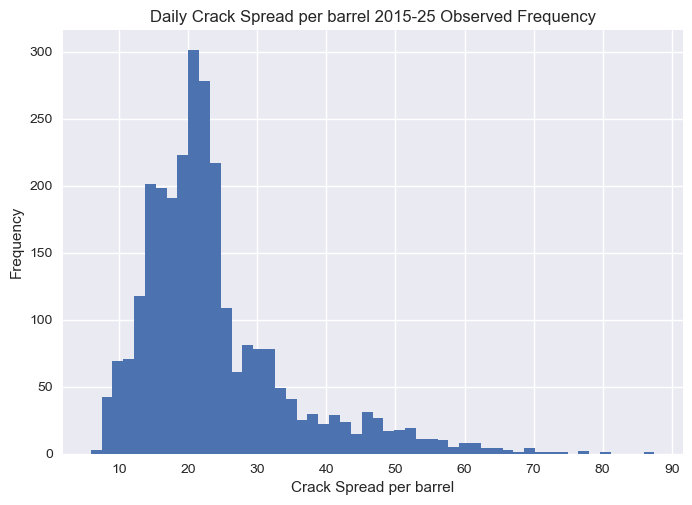

In [20]:
plt.hist(df.crack_321_per_bbl, bins = 52)
plt.title('Daily Crack Spread per barrel 2015-25 Observed Frequency')
plt.xlabel('Crack Spread per barrel')
plt.ylabel('Frequency')
plt.show()

The **empirical distribution** of the daily crack spread per barrel is found to be **right-skewed**: large positive spikes in refining margins occur more often than large negative crashes. This has direct implications for how we define “extreme” levels:

- As a baseline, we use a **simple z-score strategy**, which implicitly treats deviations as if they were drawn from a symmetric, approximately normal distribution.  
- To account for the observed skewness and potential fat tails, we also implement a **Cornish–Fisher–adjusted** version of the z-score bands, which adapts the thresholds for long/short signals to the actual higher moments (skewness and kurtosis) of the historical crack spread.

This section therefore prepares a clean, consistent crack spread series and motivates the two main signal frameworks used later in the project:  
1. Simple symmetric z-score bands  
2. Distribution-aware Cornish–Fisher–adjusted bands

## 2. Simple Z-Score Strategy

To establish a baseline trading framework, we implement a **simple symmetric z-score strategy**.  
This serves as a benchmark against which we later compare the more distribution-aware Cornish–Fisher model.

---

We begin by creating a **separate copy** of the original dataset to keep this strategy self-contained and avoid cluttering the main dataframe.

In [24]:
# Create a clean copy for the z-score strategy 

df_z = df.copy()

### 2.1 Calculating Rolling Stats and Z-Scores 

We begin by creating a separate copy of the original dataset to keep this strategy self-contained.

Using a **60-day rolling window**, we compute:
- **Rolling Mean**: $\mu_t = \text{mean}\big(\text{Crack}_{t-59:t}\big)$

- **Rolling Standard Deviation**: $\sigma_t = \text{std}\big(\text{Crack}_{t-59:t}\big)$

These rolling statistics give us a moving estimate of the “typical” level and variability of the crack spread.

A 60-day window is chosen because it strikes a practical balance between:

- **Recency** (reacts to current market conditions)  
- **Stability** (reduces noise in crack spread volatility)  
- **Seasonality effects** in refined product markets (typically operate on multi-month cycles)

Shorter windows (<20 days) become too noisy, and longer windows (>120 days) react too slowly to regime shifts in energy markets.

In [27]:
# Rolling mean and std
window = 60  

df_z['roll_mean'] = df_z['crack_321_per_bbl'].rolling(window).mean()
df_z['roll_std']  = df_z['crack_321_per_bbl'].rolling(window).std()

We then compute the **simple z-score**:

$$
z_t = \frac{\text{Crack}_{t} - \mu_t}{\sigma_t}
$$

This z-score normalizes the crack spread relative to recent history, treating extreme highs and lows symmetrically.  
Although the crack spread is empirically right-skewed, this symmetric measure provides a clean baseline for comparison.

In [29]:
# Simple z-score 
df_z['z'] = (df_z['crack_321_per_bbl'] - df_z['roll_mean']) / df_z['roll_std']

### 2.2 Signals and Trading Logic 

We define **symmetric thresholds** for entering positions:

- **Long threshold:** $z_t < -2 \quad \Rightarrow \quad \text{Buy crack spread}$

- **Short threshold:** $z_t > +2 \quad \Rightarrow \quad \text{Sell crack spread}$

In [32]:
# Symmetric thresholds - defining the number of std to trigger a buy or sell signal 

upper_z = 2.0   # short threshold 
lower_z = -2.0  # long threshold

This produces the **signal column** with values:

- `+1` → long the crack spread  
- `-1` → short the crack spread  
- `0`  → no position 

In [34]:
# Signals 

df_z['signal'] = 0
df_z.loc[df_z['z'] < lower_z, 'signal'] = 1     # long crack
df_z.loc[df_z['z'] > upper_z, 'signal'] = -1    # short crack


Because a signal observed today is executed **the next day**, we shift the signal by **one period** to create the **position** column:

$$
\text{position}_t = \text{signal}_{t-1}
$$

This is the standard backtesting convention and ensures we do not trade on information we could not have known.

In [36]:
# Positions shifted by 1 because the signal generated today is executed tomorrow

df_z['position'] = df_z['signal'].shift(1).fillna(0)

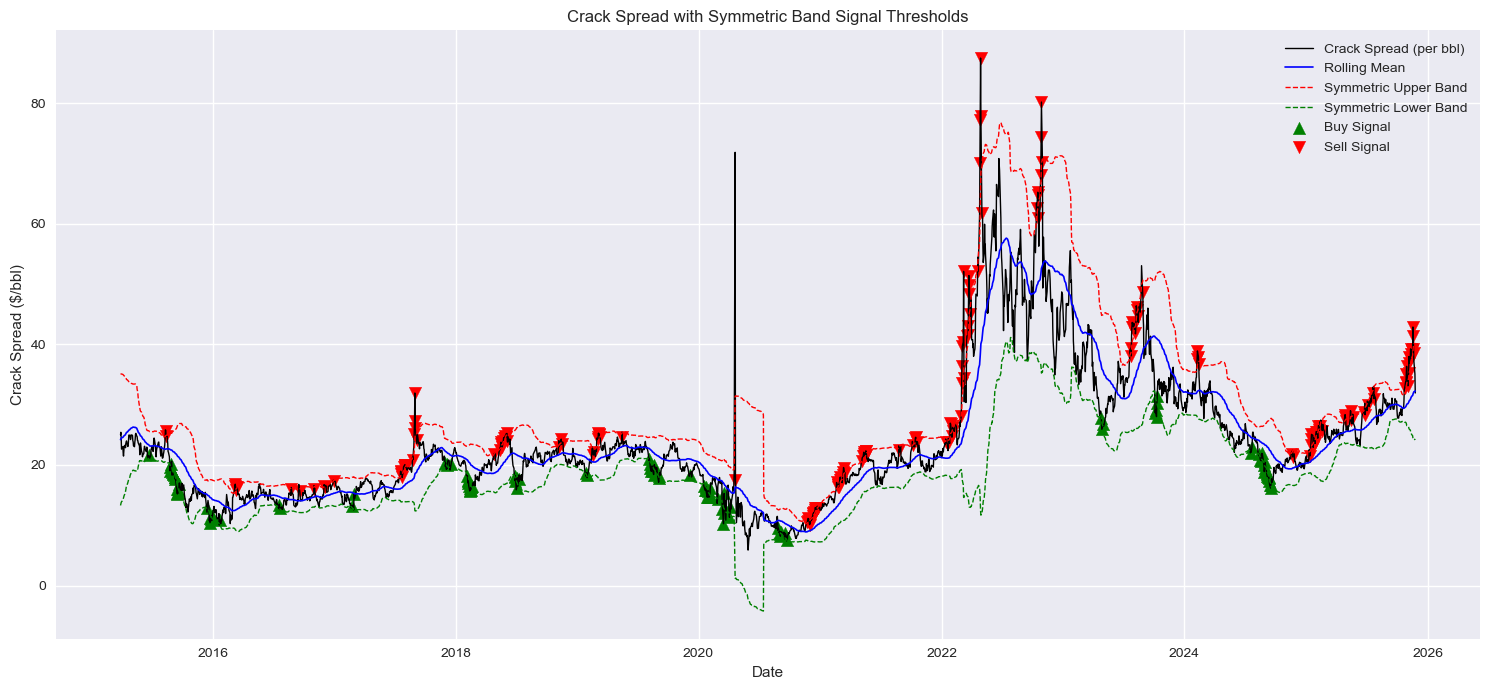

In [195]:
# Sanity Check Plot 

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Crack Spread 
plt.plot(df_z.index, df_z['crack_321_per_bbl'], label='Crack Spread (per bbl)', color='black', linewidth=1)

# Rolling Mean
plt.plot(df_z.index, df_z['roll_mean'], label='Rolling Mean', color='blue', linewidth=1.2)

# Upper/Lower Bands 
upper_z_band = df_z['roll_mean'] + upper_z * df_z['roll_std']
lower_z_band = df_z['roll_mean'] + lower_z  * df_z['roll_std']

plt.plot(df_z.index, upper_z_band, label='Symmetric Upper Band', color='red', linestyle='--', linewidth=1)
plt.plot(df_z.index, lower_z_band, label='Symmetric Lower Band', color='green', linestyle='--', linewidth=1)

# Buy Signals (Long Crack)
plt.scatter(df_z.index[df_z['position'] == 1],
            df_z['crack_321_per_bbl'][df_z['position'] == 1],
            marker='^', color='green', s=80, label='Buy Signal')

# --- Sell Signals (Short Crack) ---
plt.scatter(df_z.index[df_z['position'] == -1],
            df_z['crack_321_per_bbl'][df_z['position'] == -1],
            marker='v', color='red', s=80, label='Sell Signal')

plt.title('Crack Spread with Symmetric Band Signal Thresholds')
plt.xlabel('Date')
plt.ylabel('Crack Spread ($/bbl)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Finally, we generate a **sanity check plot** overlaying:

- the crack spread per barrel,  
- the rolling mean and ±2σ bands,  
- and the buy/sell signal markers.  

This allows us to visually confirm that signals occur where expected.

---

### 2.3 PnL Engine

To evaluate performance, we compute:

1. **Daily crack returns**  
   $$
   r_t = \text{Crack}_{t} - \text{Crack}_{t-1}
   $$

   We use point changes (not percentage changes) because crack spreads are traded as linear combinations of futures prices, where PnL is directly proportional to price changes.

2. **Daily PnL**  
   $$
   \text{PnL}_t = \text{position}_t \times r_t
   $$

3. **Cumulative PnL**  
   $$
   \text{CumPnL}_t = \sum_{i=1}^{t} \text{PnL}_i
   $$

This cumulative curve represents the unlevered performance of the simple z-score crack-spread strategy.

Finally, we **export this clean z-score strategy dataframe to CSV**, allowing reproducibility and easy comparison with the Cornish–Fisher strategy implemented later.


In [41]:
# Daily crack returns 

df_z['crack_ret'] = df_z['crack_321_per_bbl'].diff().fillna(0)

In [42]:
# PnL

df_z['pnl'] = df_z['position'] * df_z['crack_ret']
df_z['cum_pnl'] = df_z['pnl'].cumsum()

In [43]:
df_z.dropna(inplace = True)

In [44]:
df_z.to_csv('simple_zscore_strategy.csv')

## 3. Cornish-Fisher Adjusted Strategy

To incorporate the empirical **right-skew** and occasional **fat tails** observed in the crack spread distribution, we implement a Cornish–Fisher–adjusted model.  
Unlike the symmetric z-score approach, this method adapts the long/short thresholds dynamically based on rolling skewness and kurtosis.

---
As before, we work on a **separate copy** of the main dataset to keep this strategy self-contained.


In [47]:
# Create a clean copy for the CF strategy 

df_cf = df.copy()

### 3.1 Computing Rolling Stats and EWMA Mean and Std

We compute **rolling skewness and kurtosis** using a **60-day window**.  
The rationale for 60 days is the same as before: it provides enough data to estimate higher moments meaningfully while still being responsive to changes in market regimes.

In [50]:
# Rolling stats

import scipy.stats as stats

window = 60  

df_cf['skew']     = df_cf['crack_321_per_bbl'].rolling(window).skew()
df_cf['kurtosis'] = df_cf['crack_321_per_bbl'].rolling(window).kurt()

Next, we compute **EWMA mean and EWMA standard deviation** using a **20-day half-life**.  
The idea is:

- Higher moments (skew/kurtosis) require **longer** windows for stability  
- Mean and volatility benefit from **faster** adaptation, hence the shorter EWMA decay  

In [52]:
# EWMA mean and std 

half_life = 20 

df_cf['ewma_mean'] = df_cf['crack_321_per_bbl'].ewm(halflife=half_life).mean()
df_cf['ewma_std']  = df_cf['crack_321_per_bbl'].ewm(halflife=half_life).std()

This combination allows us to mix **stability** (higher moments) and **responsiveness** (level/vol).

These rolling quantities serve as inputs to the Cornish–Fisher expansion and the adjusted z-scores.

---

### 3.2 Cornish-Fisher Expansion and Computing Z Scores

#### 3.2.1 Cornish Fisher Expansion

We begin by defining **raw symmetric z-bands**:

- Left band (long trigger): $z_{\text{left}} = -1.5$
- Right band (short trigger): $z_{\text{right}} = 2.0$

These reflect the empirical right-skew: extreme positive cracks are more common, so the short side requires a wider threshold.

In [57]:
# Raw unadjusted bands 

z_left_raw  = -1.5   # long threshold
z_right_raw =  2.0   # short threshold

We then define the **Cornish–Fisher expansion**, which adjusts these thresholds for the current skew and kurtosis:

$$
z_{\text{CF}} = z 
+ \frac{s}{6}(z^2 - 1)
+ \frac{k}{24}(z^3 - 3z)
- \frac{s^2}{36}(2z^3 - 5z)
$$

In [59]:
def cornish_fisher(z, skew, kurt):
    term1 = z
    term2 = (skew/6)   * (z**2 - 1)
    term3 = (kurt/24)  * (z**3 - 3*z)
    term4 = -(skew**2/36) * (2*z**3 - 5*z)
    return term1 + term2 + term3 + term4

Applying this expansion using the rolling skewness and kurtosis yields two new daily series:

- `z_left_cf`  
- `z_right_cf`  

These become the **dynamic long and short bands** for the strategy.

In [61]:
# Apply CF-adjusted thresholds

df_cf['z_left_cf']  = cornish_fisher(z_left_raw,  df_cf['skew'], df_cf['kurtosis'])
df_cf['z_right_cf'] = cornish_fisher(z_right_raw, df_cf['skew'], df_cf['kurtosis'])

#### 3.2.2 Calculating CF-Adjusted Z scores 

Next, we compute a **CF-adjusted z-score** using the EWMA statistics:

$$
z^{\text{EWMA}}_t = \frac{\text{Crack}_{t} - \text{EWMA Mean}_t}{\text{EWMA Std}_t}
$$

This gives a more responsive measure of how “rich” or “cheap” the crack spread is relative to its recent behaviour.

In [64]:
df_cf['ewma_z'] = (df_cf['crack_321_per_bbl'] - df_cf['ewma_mean']) / df_cf['ewma_std']

### 3.3 Signals and Trading Logic 

We generate trading signals by comparing the **EWMA-based z-score** to the **CF-adjusted bands**:

- **Long signal (+1)** if $z^{\text{EWMA}}_t < z_{\text{left, CF}}(t)$

- **Short signal (–1)** if $z^{\text{EWMA}}_t > z_{\text{right, CF}}(t)$

These signals are stored in `signal_cf`.

In [67]:
df_cf['signal_cf'] = 0

# Long when crack is cheap (left tail)
df_cf.loc[df_cf['ewma_z'] < df_cf['z_left_cf'],  'signal_cf'] = 1

# Short when crack is rich (right tail)
df_cf.loc[df_cf['ewma_z'] > df_cf['z_right_cf'], 'signal_cf'] = -1

As with the simple z-score strategy, we shift the signals by one day to create the **position** column:

$$
\text{position\_cf}_t = \text{signal\_cf}_{t-1}
$$

In [69]:
# Positions shifted by 1 because the signal generated today is executed tomorrow

df_cf['position'] = df_cf['signal_cf'].shift(1).fillna(0)

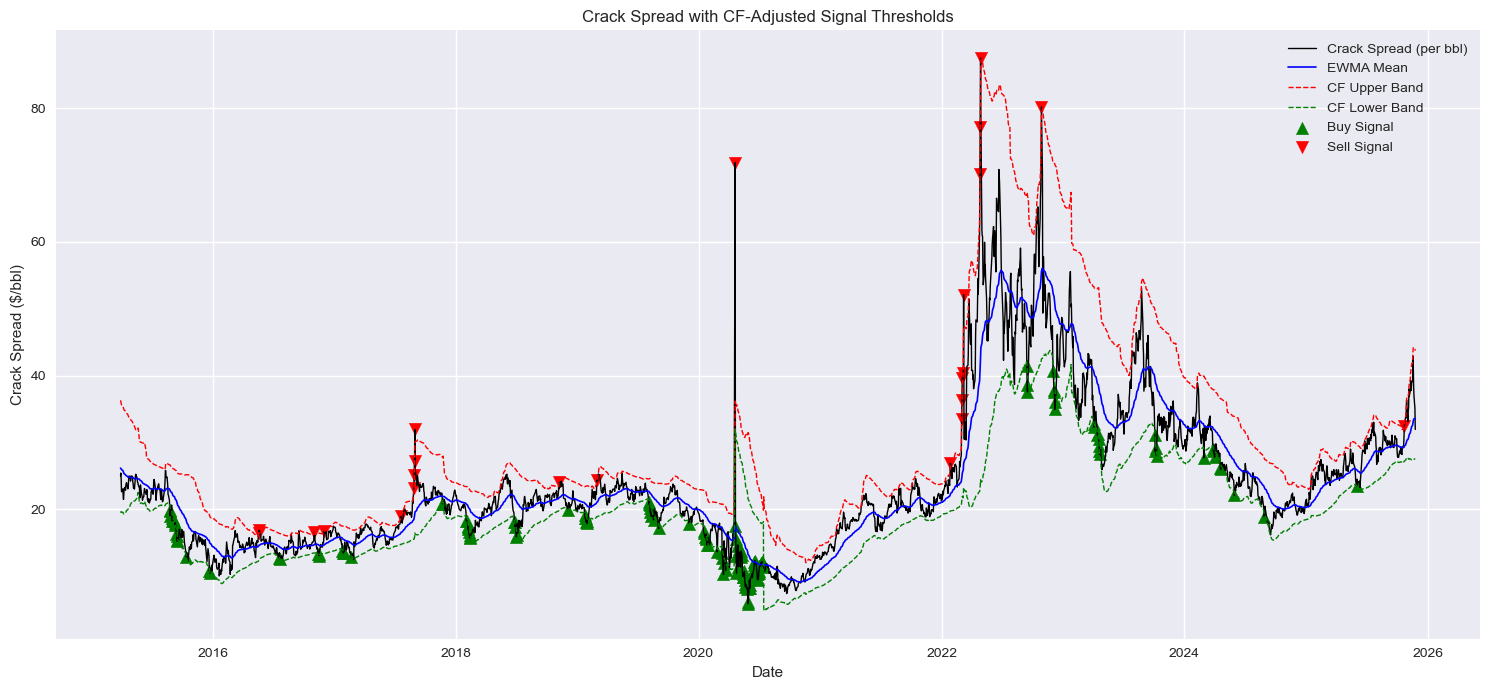

In [199]:
# Sanity check plot for signals 

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Crack Spread 
plt.plot(df_cf.index, df_cf['crack_321_per_bbl'], label='Crack Spread (per bbl)', color='black', linewidth=1)

# EWMA Mean
plt.plot(df_cf.index, df_cf['ewma_mean'], label='EWMA Mean', color='blue', linewidth=1.2)

# --- CF Adjusted Upper/Lower Bands ---
upper_cf = df_cf['ewma_mean'] + df_cf['z_right_cf'] * df_cf['ewma_std']
lower_cf = df_cf['ewma_mean'] + df_cf['z_left_cf']  * df_cf['ewma_std']

plt.plot(df_cf.index, upper_cf, label='CF Upper Band', color='red', linestyle='--', linewidth=1)
plt.plot(df_cf.index, lower_cf, label='CF Lower Band', color='green', linestyle='--', linewidth=1)

# --- Buy Signals (Long Crack) ---
plt.scatter(df_cf.index[df_cf['signal_cf'] == 1],
            df_cf['crack_321_per_bbl'][df_cf['signal_cf'] == 1],
            marker='^', color='green', s=80, label='Buy Signal')

# --- Sell Signals (Short Crack) ---
plt.scatter(df_cf.index[df_cf['signal_cf'] == -1],
            df_cf['crack_321_per_bbl'][df_cf['signal_cf'] == -1],
            marker='v', color='red', s=80, label='Sell Signal')

plt.title('Crack Spread with CF-Adjusted Signal Thresholds')
plt.xlabel('Date')
plt.ylabel('Crack Spread ($/bbl)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We then generate a **sanity-check plot** showing:

- the crack spread per barrel,  
- EWMA mean,  
- CF-adjusted dynamic bands,  
- and buy/sell markers  

to visually confirm signal correctness.

---

### 3.4 PnL Engine

The PnL computation follows the same structure as earlier:

- Daily crack returns (point changes)  
- Strategy daily PnL = position × crack return  
- Cumulative PnL built via cumulative sum  

Finally, we export the final CF-strategy dataframe to CSV for reproducibility and comparison with the simple z-score strategy.

This completes the Cornish–Fisher adjusted trading model, which accounts for the observed non-normality in crack spread behaviour.


In [74]:
# Daily crack returns 

df_cf['crack_ret'] = df_cf['crack_321_per_bbl'].diff().fillna(0)

In [75]:
# PnL

df_cf['pnl'] = df_cf['position'] * df_cf['crack_ret']
df_cf['cum_pnl'] = df_cf['pnl'].cumsum()

In [76]:
df_cf.dropna(inplace = True)

In [77]:
df_cf.to_csv('cf_adjusted_strategy.csv')

## 4. Plots and Metrics

This section presents both strategies **side-by-side**, first visually through cumulative PnL curves, and then numerically through key performance metrics.  
The goal here is not to interpret the results (that comes later), but simply to **display** them clearly and consistently.

### 4.1 Comparing Cumulative PnL Plots

We begin by aggregating the cumulative PnLs from both the **Simple Z-Score Strategy** and the **Cornish–Fisher Adjusted Strategy** into a single comparison dataframe.  
Aligning the indices ensures that both series are plotted over the same time horizon.

In [80]:
# Combine cumulative PnL series

comparison = pd.DataFrame({
    'CF_cum_pnl': df_cf['cum_pnl'],
    'Z_cum_pnl': df_z['cum_pnl']
}).dropna()

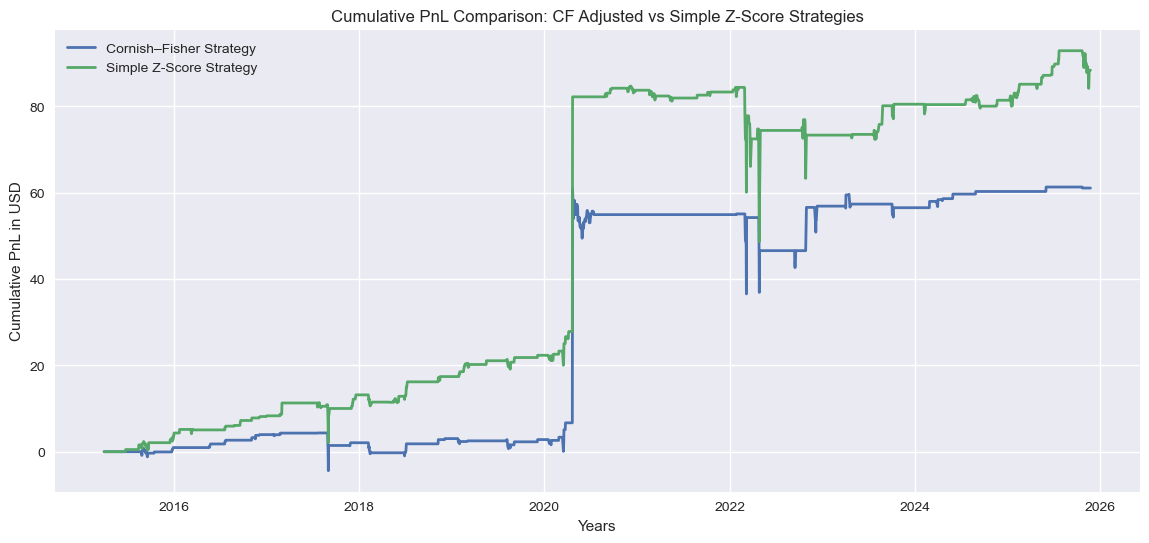

In [191]:
# Plotting cumulative PnLs

plt.figure(figsize=(14,6))
plt.plot(comparison.index, comparison['CF_cum_pnl'], label='Cornish–Fisher Strategy', linewidth=2)
plt.plot(comparison.index, comparison['Z_cum_pnl'], label='Simple Z-Score Strategy', linewidth=2)
plt.xlabel('Years')
plt.ylabel('Cumulative PnL in USD')
plt.title("Cumulative PnL Comparison: CF Adjusted vs Simple Z-Score Strategies")
plt.grid(True)
plt.legend()
plt.show()

The resulting chart displays both cumulative PnLs together, allowing an immediate visual comparison of:

- performance stability,  
- periods of outperformance,  
- volatility of returns,  
- and relative drawdowns across regimes.

This provides a high-level view of how each model behaved through the same market conditions.

---

### 4.2 Comparing Performance Metrics

To systematically compare both strategies, we define a reusable function that computes:

- **Total PnL**  
- **Annualized Sharpe Ratio** (using daily frequency)  
- **Maximum Drawdown**  
- **Number of Trades** (count of position changes)  
- **Profit per Trade** (total PnL divided by trade count)

In [83]:
# Defining function to compute metrics 

def compute_metrics(pnl_series, position_series):
    total_pnl = pnl_series.sum()
    sharpe = (pnl_series.mean() / pnl_series.std()) * np.sqrt(252)
    max_dd = (pnl_series.cumsum() - pnl_series.cumsum().cummax()).min()
    trades = position_series.diff().abs().sum()  # counts position changes
    pnl_per_trade = pnl_series.sum() / trades if trades > 0 else 0
    return total_pnl, sharpe, max_dd, trades, pnl_per_trade

These metrics capture different aspects of model performance:

- Sharpe shows risk-adjusted return  
- Max drawdown shows downside behaviour  
- Number of trades indicates turnover  
- Profit per trade highlights trading efficiency  

In [84]:
# Computing metrics 

cf_metrics = compute_metrics(df_cf['pnl'], df_cf['position'])
z_metrics  = compute_metrics(df_z['pnl'], df_z['position'])

After computing the metrics for both strategies, we present the results in a **clean comparison table**, allowing quick identification of relative strengths and weaknesses.  
This table will later be referenced in the *Observations & Inferences* section for interpretation.

In [85]:
metrics_df = pd.DataFrame({
    'Cornish–Fisher Adjusted Strategy': {
        'Total PnL': cf_metrics[0],
        'Sharpe Ratio': cf_metrics[1],
        'Max Drawdown': cf_metrics[2],
        'Number of Trades': cf_metrics[3],
        'Profit per Trade': cf_metrics[4]
    },
    'Simple Z-Score Strategy': {
        'Total PnL': z_metrics[0],
        'Sharpe Ratio': z_metrics[1],
        'Max Drawdown': z_metrics[2],
        'Number of Trades': z_metrics[3],
        'Profit per Trade': z_metrics[4]
    }
})

metrics_df = metrics_df.round(3)
metrics_df

,Cornish–Fisher Adjusted Strategy,Simple Z-Score Strategy
Total PnL,61.072,88.383
Sharpe Ratio,0.294,0.399
Max Drawdown,-24.499,-36.010
Number of Trades,108.000,230.000
Profit per Trade,0.565,0.384


## 5. Observations and Inferences

This section interprets the results from the cumulative PnL comparison and the performance metrics table.  
The goal is to understand *why* each strategy behaved the way it did and what this tells us about crack-spread dynamics.

---


### 5.1 Overall Performance Comparison

The **Simple Z-Score Strategy** outperforms the **Cornish–Fisher Adjusted Strategy** in both **Total PnL** and **Sharpe Ratio** over the full sample period:

- **Z-Score Strategy:** Higher cumulative returns and better risk-adjusted performance  
- **CF Strategy:** More stable PnL path with lower drawdowns and fewer trades  

This result is intuitive.  
The symmetric z-score model generates **more frequent signals** and therefore captures more short-term mean reversion in the crack spread.  
The CF-adjusted model, by design, triggers fewer trades because right-tail thresholds are widened to reflect the crack spread’s empirical skewness.  
As a result, it is more conservative and trades only during the most pronounced deviations.

---

### 5.2 Drawdowns and Stability

Despite generating less PnL, the **Cornish–Fisher Strategy** exhibits:

- lower **max drawdown**,  
- smoother equity curve,  
- and fewer sudden reversals.

This is because the CF model’s dynamic thresholds filter out many borderline signals that the symmetric z-score model interprets as trading opportunities.  
In periods of elevated volatility—particularly around 2020–2022—the CF model avoids several whipsaw trades that appear in the z-score strategy.

This aligns with the idea that more realistic (skew-aware) thresholds can improve stability even if they reduce raw profitability.

---


### 5.3 Turnover and Profit per Trade

Turnover differs significantly:

- **Z-Score Strategy:** 230 trades  
- **CF Strategy:** 108 trades  

The z-score model trades more than twice as often.  
This leads to:

- Higher total PnL  
- But lower **profit per trade** (0.384 vs. 0.565)  
- And higher drawdowns  

Once realistic transaction costs are included, the z-score model’s advantage would shrink, while the CF strategy—being more selective—would likely retain a larger portion of its returns.

Thus, the CF model shows **better trading efficiency**, even though the z-score model performs better in a frictionless environment.

---

### 5.4 Regime Behaviour: Structural Changes Post Russia–Ukraine Conflict

To examine whether the crack spread exhibits regime-dependent behaviour, we plot two diagnostic series:

1. **60-Day Rolling Skew** of the crack spread per barrel  
2. **60-Day Rolling Mean** of the crack spread per barrel  

Both series reveal a clear structural break around **2022**, coinciding with the beginning of the Russia–Ukraine conflict.  
A vertical annotation is added to highlight this period.

---

In [169]:
# Rolling skew and rolling mean
roll_window = 60

df_macro = pd.DataFrame(index=df.index)
df_macro['crack'] = df['crack_321_per_bbl']
df_macro['rolling_skew'] = df_macro['crack'].rolling(roll_window).skew()
df_macro['rolling_mean'] = df_macro['crack'].rolling(roll_window).mean()

#### 5.4.1 Rolling Skew: Rising Right-Tail Risk Post-2022

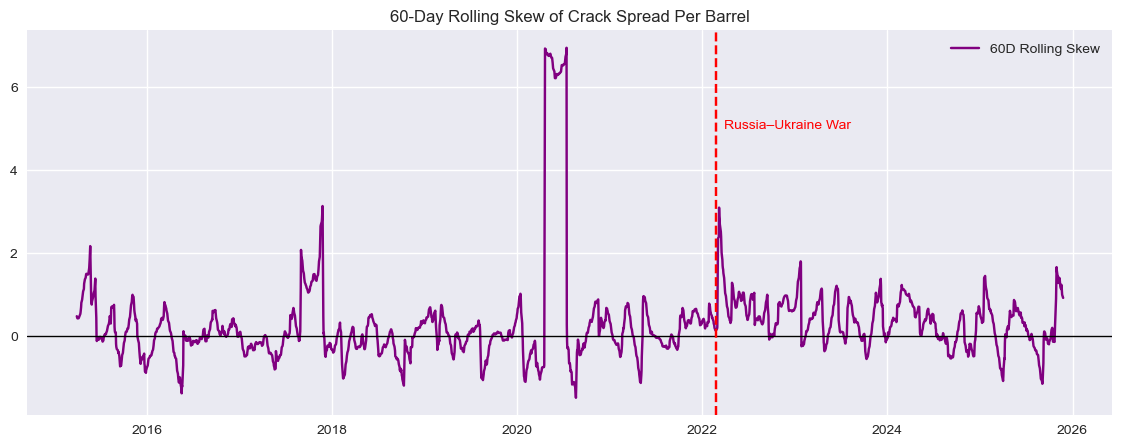

In [203]:
# Plot rolling skew
plt.figure(figsize=(14,5))
plt.plot(df_macro.index, df_macro['rolling_skew'], label='60D Rolling Skew', color='purple')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(pd.to_datetime("2022-02-24"), color='red', linestyle='--')
plt.text(pd.to_datetime("2022-03-26"), y = 5, s = "Russia–Ukraine War", color='red')
plt.title("60-Day Rolling Skew of Crack Spread Per Barrel")
plt.grid(True)
plt.legend()
plt.show()

From 2015 to early 2020, the rolling skew oscillates around zero, indicating a fairly symmetric distribution of crack spreads.  
However:

- During the Covid refinery shutdown period (2020), skew spikes sharply upward.  
- Post-2022, skew becomes **consistently positive**, with frequent right-tail surges.

This reflects structural tightening in global refined product markets:

- Loss of Russian diesel exports  
- Reduced global refining capacity  
- Scarce distillate inventories  
- Greater vulnerability to supply shocks  

The post-2022 environment therefore produces more *large positive outliers* in crack spreads — exactly the type of right-skew behaviour the Cornish–Fisher model is designed to capture.

---

#### 5.4.2 Rolling Mean: Structural Elevation of Refining Margins

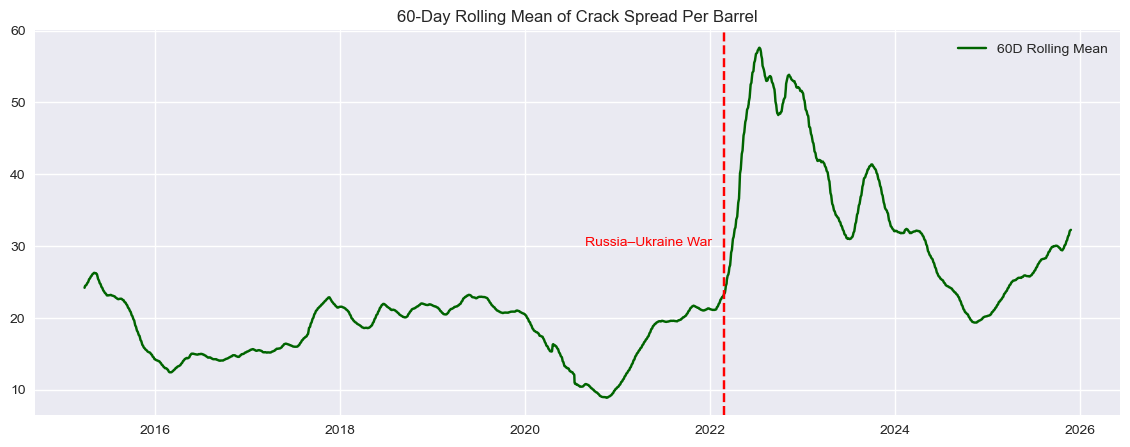

In [207]:
# Plot rolling mean
plt.figure(figsize=(14,5))
plt.plot(df_macro.index, df_macro['rolling_mean'], label='60D Rolling Mean', color='darkgreen')
plt.axvline(pd.to_datetime("2022-02-24"), color='red', linestyle='--')
plt.text(pd.to_datetime("2020-08-26"), y = 30, s = "Russia–Ukraine War", color='red')
plt.title("60-Day Rolling Mean of Crack Spread Per Barrel")
plt.grid(True)
plt.legend()
plt.show()

The 60-day rolling mean of the crack spread shows a dramatic and persistent jump after 2022:

- Pre-2020 levels mostly ranged between **USD 10–25 per barrel**  
- During the 2022 sanctions and supply dislocations, rolling mean surged above **USD 50 per barrel**  
- Even after normalisation, margins remained structurally higher than the pre-2022 era

This reflects the new macro structure of refined product markets:

- Chronic underinvestment in refining  
- European reliance on imported distillates  
- Global shortage of diesel and jet fuel  
- Larger seasonal and geopolitical dislocations

The structural rise in both **mean** and **skew** provides a macro rationale for the regime change seen in the cumulative PnL curves earlier.

---

#### 5.4.3 Implications for the Trading Strategies

- The **Simple Z-Score Strategy** captures more opportunities in the high-volatility, right-skewed post-2022 regime, explaining its higher total PnL.  
- The **CF-Adjusted Strategy**, being more conservative, avoids many of the sharp spikes and reversals, leading to fewer trades but smoother PnL.  
- The right-skew environment naturally favours strategies with higher turnover; however, this comes with more drawdowns and lower profit per trade.

Overall, the macro regime shift post-2022 materially influenced crack spread behaviour, and therefore the relative performance of the two strategies.


### 5.5 Summary of Key Insights

- The **simple z-score strategy** is more aggressive, trades more often, and achieves higher PnL and Sharpe but at the cost of more volatility and deeper drawdowns.
- The **CF-adjusted strategy** is more conservative and selective, yielding a smoother PnL curve, lower drawdown, and higher profit per trade.
- The right-skewed crack distribution justifies the use of asymmetric or CF-adjusted thresholds, even if they do not always outperform in raw returns.
- Structural changes post-2022 significantly affected crack-spread behaviour, highlighting the importance of regime awareness in commodity spread trading.
- Including realistic transaction costs would likely narrow the performance gap, making the CF strategy more competitive.

Together, these observations illustrate the trade-off between **frequency-driven returns** (z-score) and **robust, distribution-aware trading** (Cornish–Fisher), while also highlighting important structural features of the crude product markets.